In [137]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import PIL
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import random
from tensorflow.keras import layers
from keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [138]:
current_dir = os.getcwd()
print(current_dir)

c:\Users\marzi\Downloads


In [139]:
base_dir = "C://Users//marzi//Documents//LAG_dataset"
print(base_dir)

C://Users//marzi//Documents//LAG_dataset


In [140]:
import os
import shutil
from sklearn.model_selection import train_test_split
from shutil import rmtree

data_dir = current_dir + "//model//ResNet-101//LAG"
train_dir = data_dir + "//train"
test_dir = data_dir + "//test" 
val_dir = data_dir + "//val"

if os.path.exists(data_dir):
	rmtree(data_dir)

# Definisci la proporzione di suddivisione (es: 0.7 per il 70% nel train e il 30% nel test + val)
train_ratio = 0.7
# Definisci la proporzione di suddivisione del set di test (50% in test e 50% in val)
test_val_ratio = 0.5

# Crea le cartelle train, test e val se non esistono
os.makedirs(data_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Per ogni classe nella cartella dataset
for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if os.path.isdir(class_path):
        # Crea le sottocartelle per ogni classe nelle cartelle train, test e val
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        # Ottieni la lista delle immagini
        images = os.listdir(class_path)

        # Dividi in train e test+val
        train_images, test_val_images = train_test_split(images, train_size=train_ratio, random_state=42)

        # Dividi ulteriormente test+val in test e val
        test_images, val_images = train_test_split(test_val_images, train_size=test_val_ratio, random_state=42)

        # Sposta le immagini nella rispettiva cartella
        for image in train_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))

        for image in test_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))

        for image in val_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(val_dir, class_name, image))

print("Divisione train, test e val completata!")

Divisione train, test e val completata!


In [163]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input
datagen_train = ImageDataGenerator(preprocessing_function=preprocess_input,
shear_range = 0.1,
zoom_range = 0.1,
rotation_range = 20,
width_shift_range = 0.1,
height_shift_range = 0.1,
horizontal_flip = False,
vertical_flip = False,
fill_mode='nearest')

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = datagen_train.flow_from_directory(
    train_dir,
    class_mode='categorical',
    shuffle=False)

val_ds = datagen.flow_from_directory(
    val_dir,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    test_dir,
    class_mode='categorical',
    shuffle=False)


Found 3397 images belonging to 2 classes.
Found 729 images belonging to 2 classes.
Found 728 images belonging to 2 classes.


In [165]:
print((train_ds.samples) +(val_ds).samples+ (test_ds.samples))

4854


In [80]:
# bilanciamento del dataset
from sklearn.utils import class_weight
import numpy as np

# Calcola i pesi delle classi
labels = train_ds.classes
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..131.32].


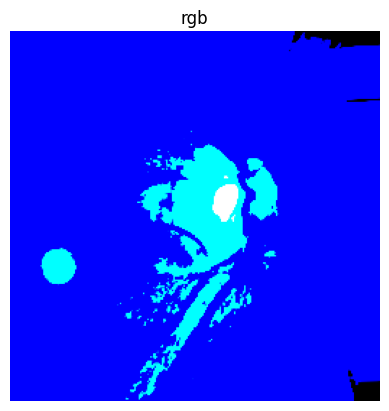

In [81]:
# Retrieve a batch of images and labels
images, labels = next(train_ds)

# Display the first image in the batch
plt.imshow(images[0])
plt.title('rgb')
plt.axis('off')  # Turn off axis
plt.show()

In [53]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adamax
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import silu

# Carica il modello VGG16 pre-addestrato senza i livelli fully connected alla fine
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

model_resnet101 = Sequential()

# Congela i pesi del modello base
for layer in base_model.layers[-5:]:
    layer.trainable = True

model_resnet101.add(base_model)

# Full connection
model_resnet101.add(Flatten())
model_resnet101.add(Dense(units = 1028, activation = 'relu'))
model_resnet101.add(BatchNormalization()),
model_resnet101.add(Dense(512,activation='relu')),
model_resnet101.add(Dropout(0.25)),
model_resnet101.add(Dense(units = 2, activation = 'softmax'))

# Compila il modello
learning_rate = 0.000005
model_resnet101.compile(optimizer=Adamax(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [54]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Definizione della callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',  # Monitora la loss sul set di validazione
                               patience=5,          # Numero di epoche senza miglioramenti prima di fermarsi
                               restore_best_weights=True)  # Ripristina i pesi del miglior modello

# Definizione della callback ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # Monitora la loss sul set di validazione
                              factor=0.2,          # Fattore di riduzione del tasso di apprendimento
                              patience=3,          # Numero di epoche senza miglioramenti prima di ridurre il tasso
                              min_lr=1e-7)         # Limite inferiore per il tasso di apprendimento

initial_epochs = 50

# Train the model
model_info = model_resnet101.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=test_ds,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


c:\Users\marzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


107/107 ━━━━━━━━━━━━━━━━━━━━ 349s 3s/step - accuracy: 0.4985 - loss: 0.9231 - val_accuracy: 0.5563 - val_loss: 0.7789 - learning_rate: 5.0000e-06
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - accuracy: 0.5885 - loss: 0.7966 - val_accuracy: 0.6264 - val_loss: 0.6611 - learning_rate: 5.0000e-06
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - accuracy: 0.6728 - loss: 0.6380 - val_accuracy: 0.6882 - val_loss: 0.5667 - learning_rate: 5.0000e-06
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 331s 3s/step - accuracy: 0.6982 - loss: 0.5879 - val_accuracy: 0.7074 - val_loss: 0.5296 - learning_rate: 5.0000e-06
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 331s 3s/step - accuracy: 0.7587 - loss: 0.5018 - val_accuracy: 0.7349 - val_loss: 0.4994 - learning_rate: 5.0000e-06
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - accuracy: 0.7697 - loss: 0.4893 - val_accuracy: 0.7624 - val_loss: 0.4777 - learning_rate: 5.0000e-06
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 331s 3s/step - accuracy: 0.81

In [100]:
model_resnet101.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)          │ (None, 8, 8, 2048)     │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1028)           │   134,743,044 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1028)           │         4,112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       526,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 450,588,596 (1.68 GB)

 Trainable params: 136,327,694 (520.05 MB)

 Non-trainable params: 41,605,512 (158.71 MB)

 Optimizer params: 272,655,390 (1.02 GB)

In [55]:
print(model_info.history['accuracy'])

[0.5175154805183411, 0.6111274361610413, 0.6850162148475647, 0.7218133807182312, 0.7677362561225891, 0.7871651649475098, 0.8183691501617432, 0.8492787480354309, 0.8663526773452759, 0.8999117016792297, 0.8937297463417053, 0.9199293255805969, 0.9261112809181213, 0.9370032548904419, 0.9370032548904419, 0.9487783312797546, 0.954960286617279, 0.9587871432304382, 0.9673241376876831, 0.9682072401046753, 0.9620253443717957, 0.9743891954421997, 0.9661465883255005, 0.9746835231781006, 0.9752722978591919, 0.977038562297821, 0.9732116460800171, 0.9720341563224792, 0.9788048267364502, 0.9767441749572754, 0.9793936014175415, 0.9817485809326172, 0.9790992140769958]


In [56]:
print(model_info.history['val_accuracy'])

[0.5563187003135681, 0.6263736486434937, 0.6881868243217468, 0.7074176073074341, 0.7348901033401489, 0.7623626589775085, 0.7623626589775085, 0.7884615659713745, 0.7788461446762085, 0.7857142686843872, 0.791208803653717, 0.8118131756782532, 0.807692289352417, 0.8296703100204468, 0.8200549483299255, 0.8324176073074341, 0.8200549483299255, 0.8310439586639404, 0.8406593203544617, 0.8324176073074341, 0.8365384340286255, 0.833791196346283, 0.8365384340286255, 0.8310439586639404, 0.8324176073074341, 0.8310439586639404, 0.8324176073074341, 0.8365384340286255, 0.8255494236946106, 0.8324176073074341, 0.8296703100204468, 0.8310439586639404, 0.8282967209815979]


In [57]:
report_dir = data_dir + "//model_info"
file_name = "resnet101acc"

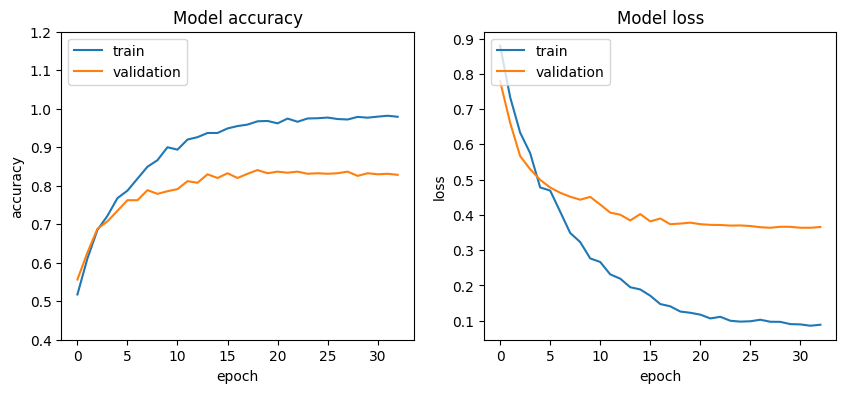

<Figure size 640x480 with 0 Axes>

In [58]:
def plot_train_history(history, report_dir, file_name):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(0.4,1.2)
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    if not os.path.exists(report_dir):
        os.makedirs(report_dir)
    file_path = os.path.join(report_dir, file_name)
    plt.savefig(file_path)
    

plot_train_history(model_info, report_dir, file_name)

In [59]:
# evaluate model accuracy
score=model_resnet101.evaluate(test_ds)
print("Loss:",score[0],"Accuracy:",score[1])

23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7711 - loss: 0.5029
Loss: 0.3635905683040619 Accuracy: 0.8365384340286255


In [60]:
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sb

In [61]:
pred= np.round(model_resnet101.predict(test_ds, verbose=1))
test_labels=test_ds.labels
test_pred_labels=[]
for i in range(len(pred)):
  test_pred_labels.append(np.argmax(pred[i]))
conf_matrix_resnet101 = confusion_matrix(test_pred_labels,test_labels)
print (conf_matrix_resnet101)

23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step
[[181  43]
 [ 76 428]]


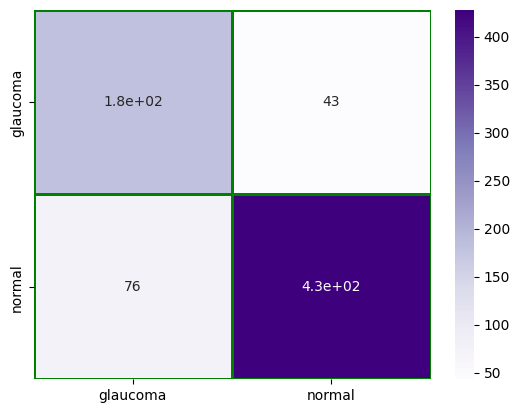

In [62]:
sb.heatmap(conf_matrix_resnet101,cmap='Purples', annot=True,xticklabels=['glaucoma','normal'],yticklabels=['glaucoma','normal'],linewidths=1,
                linecolor='green').plot()
plt.show()

In [63]:
# Precisione
def precision(TP, FP):
    return TP / (TP + FP)

# Sensibilità
def recall(TP, FN):
    return TP / (TP + FN)

# Specificità
def specificity(TN, FP):
    return TN / (TN + FP)

# f1-score
def f1(precision, recall):
    return 2 * (precision * recall) / (precision + recall)

# f2-score (dando maggior peso al recall)
def f2(precision, recall, b=2):
    return (1 + b**2) * (precision * recall) / ((b**2 * precision) + recall)

TP, FN, FP, TN = conf_matrix_resnet101.ravel()

# Calcola le metriche
p = precision(TP, FP)
r = recall(TP, FN)

# Stampa i risultati formattati
print("Precision: ", f"{p:.3f}")
print("Sensitivity: ", f"{r:.3f}")
print("Specificity: ", f"{specificity(TN, FP):.3f}")
print("f1-score: ", f"{f1(p, r):.3f}")
print("f2-score: ", f"{f2(p, r):.3f}")

Precision:  0.704
Sensitivity:  0.808
Specificity:  0.849
f1-score:  0.753
f2-score:  0.785


In [70]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Ottieni le etichette reali e le predizioni del modello
test_labels = []
pred_resnet101 = []

# Itera su tutti i batch del generatore di test
for i in range(len(test_ds)):
    images, labels = test_ds[i]
    test_labels.extend(labels)
    pred_batch = model_resnet101.predict(images)
    pred_resnet101.extend(pred_batch)

# Converti in numpy array
test_labels = np.array(test_labels)
pred_resnet101 = np.array(pred_resnet101)

# Se le etichette sono one-hot, convertili a 1D
if test_labels.ndim > 1:
    test_labels = np.argmax(test_labels, axis=1)

# Se pred è 2D (con probabilità per ogni classe), prendi solo la probabilità della classe positiva
if pred_resnet101.ndim > 1:
    pred_resnet101 = pred_resnet101[:, 1]

# Step 2: Calcola la curva ROC e l'AUC
fpr_resnet101, tpr_resnet101, _ = roc_curve(test_labels, pred_resnet101)
roc_auc_resnet101 = auc(fpr_resnet101, tpr_resnet101)

# Step 3: Traccia la curva ROC
plt.figure()
plt.plot(fpr_resnet101, tpr_resnet101, color='darkorange', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc_resnet101)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet-101 model')
plt.legend(loc="lower right")
plt.show()

# Stampa l'AUC
print('AUC = %0.3f' % roc_auc_resnet101)


ValueError: y_true takes value in {} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

In [144]:
### model 2 : ResNet50

In [82]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import silu

# Carica il modello VGG16 pre-addestrato senza i livelli fully connected alla fine
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model_resnet50.trainable = False

model_resnet50 = Sequential()

# Congela i pesi del modello base
for layer in base_model_resnet50.layers[-5:]:
    layer.trainable = True

model_resnet50.add(base_model_resnet50)

# Full connection
model_resnet50.add(Flatten())
model_resnet50.add(Dense(units = 1028, activation = 'relu'))
model_resnet50.add(BatchNormalization()),
model_resnet50.add(Dense(512,activation='relu')),
model_resnet50.add(Dropout(0.25)),
model_resnet50.add(Dense(units = 2, activation = 'softmax'))

# Compila il modello
learning_rate = 0.000005
model_resnet50.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [83]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Definizione della callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',  # Monitora la loss sul set di validazione
                               patience=5,          # Numero di epoche senza miglioramenti prima di fermarsi
                               restore_best_weights=True)  # Ripristina i pesi del miglior modello

# Definizione della callback ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # Monitora la loss sul set di validazione
                              factor=0.2,          # Fattore di riduzione del tasso di apprendimento
                              patience=3,          # Numero di epoche senza miglioramenti prima di ridurre il tasso
                              min_lr=1e-7)         # Limite inferiore per il tasso di apprendimento

initial_epochs = 50

# Train the model
model_info_resnet50 = model_resnet50.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=test_ds,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


c:\Users\marzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


107/107 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.5948 - loss: 0.9183 - val_accuracy: 0.6387 - val_loss: 0.6630 - learning_rate: 5.0000e-06
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.7367 - loss: 0.5414 - val_accuracy: 0.7527 - val_loss: 0.5076 - learning_rate: 5.0000e-06
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.8642 - loss: 0.3272 - val_accuracy: 0.8022 - val_loss: 0.4192 - learning_rate: 5.0000e-06
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.9160 - loss: 0.2220 - val_accuracy: 0.7802 - val_loss: 0.4622 - learning_rate: 5.0000e-06
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.9434 - loss: 0.1760 - val_accuracy: 0.7981 - val_loss: 0.4221 - learning_rate: 5.0000e-06
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.9633 - loss: 0.1299 - val_accuracy: 0.7926 - val_loss: 0.4262 - learning_rate: 5.0000e-06
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.97

In [84]:
report_dir = data_dir + "//model_info"
file_name = "resnet50acc"

In [152]:
def list_files_in_subdirectories(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_list.append(os.path.join(root, file))
    return file_list

# Directory delle immagini di test
test_dir = test_dir

# Ottieni la lista di tutti i file nella directory di test
test_images_filenames = list_files_in_subdirectories(test_dir)

In [155]:
def glaucoma_prediction(test_image):
    image = img_to_array(test_image)
    image = np.expand_dims(image, axis=0)
    result = np.argmax(model_resnet50.predict(image))
    return result

predictions=[]
for i in test_images_filenames:
    test_image = load_img(i, target_size = (256,256))
    pred = glaucoma_prediction(test_image)
    predictions.append(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━

In [95]:
model_resnet50.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1028)           │   134,743,044 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1028)           │         4,112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 512)            │       526,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 431,518,132 (1.61 GB)

 Trainable params: 136,327,694 (520.05 MB)

 Non-trainable params: 22,535,048 (85.96 MB)

 Optimizer params: 272,655,390 (1.02 GB)

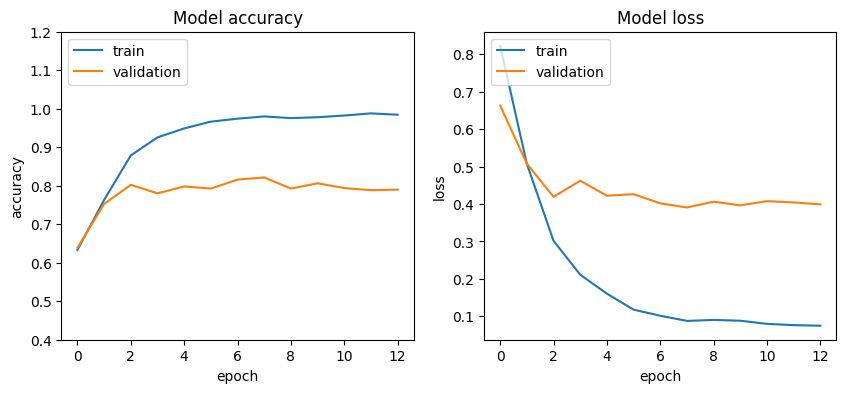

<Figure size 640x480 with 0 Axes>

In [85]:
plot_train_history(model_info_resnet50, report_dir, file_name)

In [86]:
# evaluate model accuracy
score_resnet50=model_resnet50.evaluate(test_ds)
print("Loss:",score_resnet50[0],"Accuracy:",score_resnet50[1])

23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7520 - loss: 0.5126
Loss: 0.39090201258659363 Accuracy: 0.8214285969734192


In [88]:
pred= np.round(model_resnet50.predict(test_ds, verbose=1))
test_pred_labels=[]
for i in range(len(pred)):
  test_pred_labels.append(np.argmax(pred[i]))
conf_matrix_resnet50= confusion_matrix(test_pred_labels,test_labels)
print (conf_matrix_resnet50)

23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step


ValueError: Found input variables with inconsistent numbers of samples: [728, 0]

In [ ]:
# extract cf matrix entries
TP, FN, FP, TN = conf_matrix_resnet50.ravel()

p = precision(TP, FP)

r = recall(TP, FN)

# Stampa i risultati formattati
print("Precision: ", f"{p:.3f}")
print("Sensitivity: ", f"{r:.3f}")
print("Specificity: ", f"{specificity(TN, FP):.3f}")
print("f1-score: ", f"{f1(p, r):.3f}")
print("f2-score: ", f"{f2(p, r):.3f}")

Precision:  0.732
Sensitivity:  0.866
Specificity:  0.865
f1-score:  0.793
f2-score:  0.836


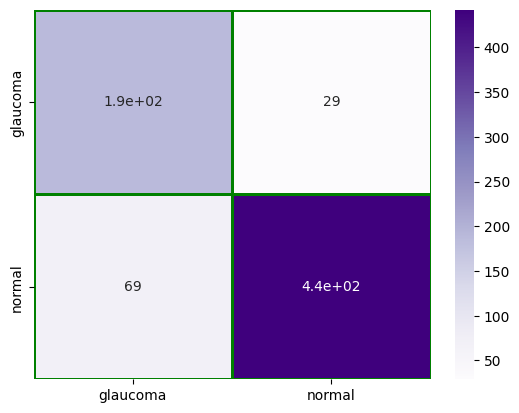

In [ ]:
sb.heatmap(conf_matrix_resnet50,cmap='Purples', annot=True,xticklabels=['glaucoma','normal'],yticklabels=['glaucoma','normal'],linewidths=1,
                linecolor='green').plot()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


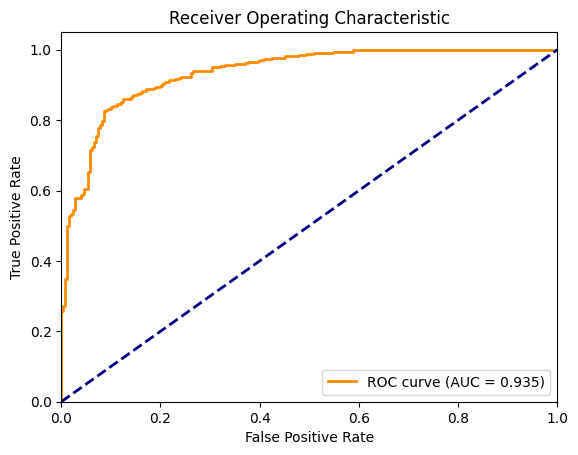

AUC = 0.935


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Ottieni le etichette reali e le predizioni del modello
test_labels = []
pred_resnet50 = []

# Itera su tutti i batch del generatore di test
for i in range(len(test_ds)):
    images, labels = test_ds[i]
    test_labels.extend(labels)
    pred_batch = model_resnet50.predict(images)
    pred_resnet50.extend(pred_batch)

# Converti in numpy array
test_labels = np.array(test_labels)
pred_resnet50 = np.array(pred_resnet50)

# Se le etichette sono one-hot, convertili a 1D
if test_labels.ndim > 1:
    test_labels = np.argmax(test_labels, axis=1)

# Se pred è 2D (con probabilità per ogni classe), prendi solo la probabilità della classe positiva
if pred_resnet50.ndim > 1:
    pred_resnet50 = pred_resnet50[:, 1]

# Step 2: Calcola la curva ROC e l'AUC
fpr_resnet50, tpr_resnet50, _ = roc_curve(test_labels, pred_resnet50)
roc_auc_resnet50 = auc(fpr_resnet50, tpr_resnet50)

# Step 3: Traccia la curva ROC
plt.figure()
plt.plot(fpr_resnet50, tpr_resnet50, color='darkorange', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc_resnet50)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Stampa l'AUC
print('AUC = %0.3f' % roc_auc_resnet50)


In [89]:
### model 3 : VGG16 needs different data preprocessing

In [90]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
datagen_train_vgg = ImageDataGenerator(preprocessing_function=preprocess_input,
shear_range = 0.1,
zoom_range = 0.1,
rotation_range = 20,
width_shift_range = 0.1,
height_shift_range = 0.1,
horizontal_flip = False,
vertical_flip = False,
fill_mode='nearest')

datagen_vgg = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = datagen_train_vgg.flow_from_directory(
    train_dir,
    class_mode='categorical',
    shuffle=False)

val_ds = datagen_vgg.flow_from_directory(
    val_dir,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen_vgg.flow_from_directory(
    test_dir,
    class_mode='categorical',
    shuffle=False)


Found 3397 images belonging to 2 classes.
Found 729 images belonging to 2 classes.
Found 728 images belonging to 2 classes.


In [92]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import silu

# Carica il modello VGG16 pre-addestrato senza i livelli fully connected alla fine
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model_vgg.trainable = False

model_vgg = Sequential()

# Congela i pesi del modello base
for layer in base_model_vgg.layers[-5:]:
    layer.trainable = True

model_vgg.add(base_model_vgg)

# Full connection
model_vgg.add(Flatten())
model_vgg.add(Dense(units = 1028, activation = 'relu'))
model_vgg.add(BatchNormalization()),
model_vgg.add(Dense(512,activation='relu')),
model_vgg.add(Dropout(0.25)),
model_vgg.add(Dense(units = 2, activation = 'softmax'))

# Compila il modello
learning_rate = 0.00001
model_vgg.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [94]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Definizione della callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',  # Monitora la loss sul set di validazione
                               patience=5,          # Numero di epoche senza miglioramenti prima di fermarsi
                               restore_best_weights=True)  # Ripristina i pesi del miglior modello

# Definizione della callback ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # Monitora la loss sul set di validazione
                              factor=0.2,          # Fattore di riduzione del tasso di apprendimento
                              patience=3,          # Numero di epoche senza miglioramenti prima di ridurre il tasso
                              min_lr=1e-7)         # Limite inferiore per il tasso di apprendimento

initial_epochs = 50

# Train the model
model_info_vgg = model_vgg.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=test_ds,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


c:\Users\marzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


107/107 ━━━━━━━━━━━━━━━━━━━━ 348s 3s/step - accuracy: 0.5823 - loss: 0.8148 - val_accuracy: 0.6923 - val_loss: 0.6177 - learning_rate: 1.0000e-05
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 348s 3s/step - accuracy: 0.6646 - loss: 0.6498 - val_accuracy: 0.7060 - val_loss: 0.5404 - learning_rate: 1.0000e-05
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 344s 3s/step - accuracy: 0.8209 - loss: 0.4289 - val_accuracy: 0.7706 - val_loss: 0.4479 - learning_rate: 1.0000e-05
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 346s 3s/step - accuracy: 0.9101 - loss: 0.2445 - val_accuracy: 0.7885 - val_loss: 0.4382 - learning_rate: 1.0000e-05
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 346s 3s/step - accuracy: 0.9638 - loss: 0.1441 - val_accuracy: 0.7940 - val_loss: 0.4317 - learning_rate: 1.0000e-05
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 345s 3s/step - accuracy: 0.9802 - loss: 0.0965 - val_accuracy: 0.7802 - val_loss: 0.4334 - learning_rate: 1.0000e-05
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 346s 3s/step - accuracy: 0.98

In [96]:
report_dir = data_dir + "//model_info"
file_name = "vgg16acc"

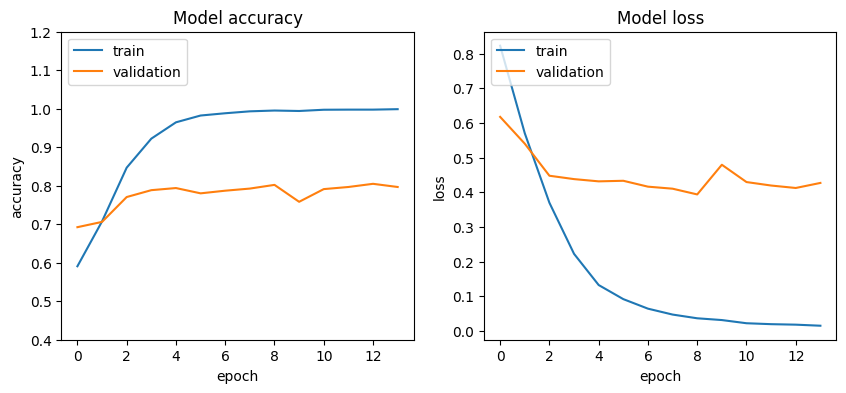

<Figure size 640x480 with 0 Axes>

In [97]:
plot_train_history(model_info_vgg, report_dir, file_name)

In [98]:
# evaluate model accuracy
score_vgg=model_vgg.evaluate(test_ds)
print("Loss:",score_vgg[0],"Accuracy:",score_vgg[1])

23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.6736 - loss: 0.6128
Loss: 0.3939994275569916 Accuracy: 0.8021978139877319


In [ ]:
pred_vgg= np.round(model_vgg.predict(test_ds, verbose=1))
test_pred_labels_vgg=[]
for i in range(len(pred_vgg)):
  test_pred_labels_vgg.append(np.argmax(pred_vgg[i]))
conf_matrix_vgg= confusion_matrix(test_pred_labels_vgg,test_labels)
print (conf_matrix_vgg)

23/23 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step
[[159  41]
 [ 98 430]]


In [ ]:
# extract cf matrix entries
TP, FN, FP, TN = conf_matrix_vgg.ravel()

p = precision(TP, FP)

r = recall(TP, FN)

# Stampa i risultati formattati
print("Precision: ", f"{p:.3f}")
print("Sensitivity: ", f"{r:.3f}")
print("Specificity: ", f"{specificity(TN, FP):.3f}")
print("f1-score: ", f"{f1(p, r):.3f}")
print("f2-score: ", f"{f2(p, r):.3f}")

Precision:  0.619
Sensitivity:  0.795
Specificity:  0.814
f1-score:  0.696
f2-score:  0.752


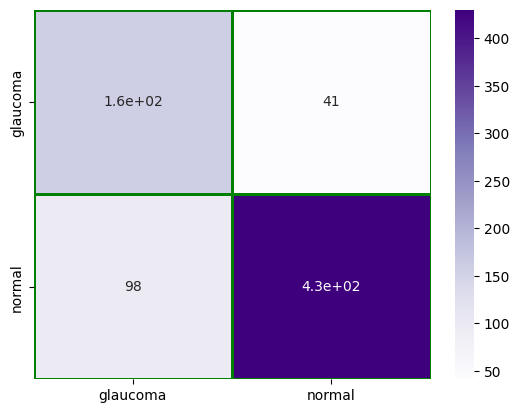

In [ ]:
sb.heatmap(conf_matrix_vgg,cmap='Purples', annot=True,xticklabels=['glaucoma','normal'],yticklabels=['glaucoma','normal'],linewidths=1,
                linecolor='green').plot()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


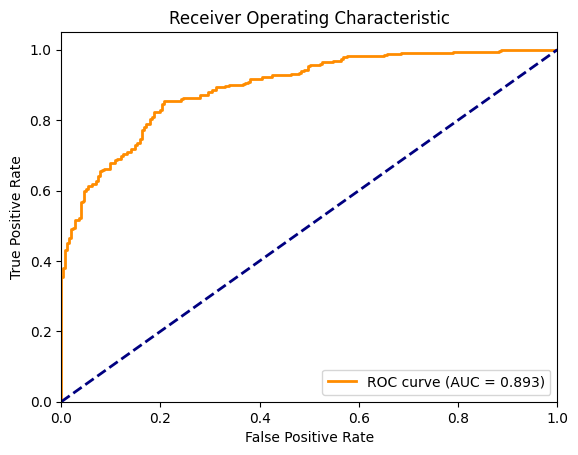

AUC = 0.893


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Ottieni le etichette reali e le predizioni del modello
test_labels = []
pred_vgg = []

# Itera su tutti i batch del generatore di test
for i in range(len(test_ds)):
    images, labels = test_ds[i]
    test_labels.extend(labels)
    pred_batch_vgg = model_vgg.predict(images)
    pred_vgg.extend(pred_batch_vgg)

# Converti in numpy array
test_labels = np.array(test_labels)
pred_vgg = np.array(pred_vgg)

# Se le etichette sono one-hot, convertili a 1D
if test_labels.ndim > 1:
    test_labels = np.argmax(test_labels, axis=1)

# Se pred è 2D (con probabilità per ogni classe), prendi solo la probabilità della classe positiva
if pred_vgg.ndim > 1:
    pred_vgg = pred_vgg[:, 1]

# Step 2: Calcola la curva ROC e l'AUC
fpr_vgg, tpr_vgg, _ = roc_curve(test_labels, pred_vgg)
roc_auc_vgg = auc(fpr_vgg, tpr_vgg)

# Step _vgg: Traccia la curva ROC
plt.figure()
plt.plot(fpr_vgg, tpr_vgg, color='darkorange', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc_vgg)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Stampa l'AUC
print('AUC = %0.3f' % roc_auc_vgg)


In [109]:
### model 4 : DenseNet-201 needs different data preprocessing

In [110]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import preprocess_input
datagen_train_densenet121 = ImageDataGenerator(preprocessing_function=preprocess_input,
shear_range = 0.1,
zoom_range = 0.1,
rotation_range = 20,
width_shift_range = 0.1,
height_shift_range = 0.1,
horizontal_flip = False,
vertical_flip = False,
fill_mode='nearest')

datagen_densenet121 = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = datagen_train_densenet121.flow_from_directory(
    train_dir,
    class_mode='categorical',
    shuffle=False)

val_ds = datagen_densenet121.flow_from_directory(
    val_dir,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen_densenet121.flow_from_directory(
    test_dir,
    class_mode='categorical',
    shuffle=False)


Found 3397 images belonging to 2 classes.
Found 729 images belonging to 2 classes.
Found 728 images belonging to 2 classes.


In [111]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import silu

# Carica il modello VGG16 pre-addestrato senza i livelli fully connected alla fine
base_model_densenet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model_densenet121.trainable = False

model_densenet121 = Sequential()

# Congela i pesi del modello base
for layer in base_model_densenet121.layers[-5:]:
    layer.trainable = True

model_densenet121.add(base_model_densenet121)

# Full connection
model_densenet121.add(Flatten())
model_densenet121.add(Dense(units = 1028, activation = 'relu'))
model_densenet121.add(BatchNormalization()),
model_densenet121.add(Dense(512,activation='relu')),
model_densenet121.add(Dropout(0.25)),
model_densenet121.add(Dense(units = 2, activation = 'softmax'))

# Compila il modello
learning_rate = 0.00001
model_densenet121.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [112]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Definizione della callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',  # Monitora la loss sul set di validazione
                               patience=5,          # Numero di epoche senza miglioramenti prima di fermarsi
                               restore_best_weights=True)  # Ripristina i pesi del miglior modello

# Definizione della callback ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # Monitora la loss sul set di validazione
                              factor=0.2,          # Fattore di riduzione del tasso di apprendimento
                              patience=3,          # Numero di epoche senza miglioramenti prima di ridurre il tasso
                              min_lr=1e-7)         # Limite inferiore per il tasso di apprendimento

initial_epochs = 50

# Train the model
model_info_densenet121 = model_densenet121.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=test_ds,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


c:\Users\marzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


107/107 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.5543 - loss: 0.9119 - val_accuracy: 0.6538 - val_loss: 0.6424 - learning_rate: 1.0000e-05
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.7494 - loss: 0.5318 - val_accuracy: 0.6511 - val_loss: 0.6793 - learning_rate: 1.0000e-05
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.8427 - loss: 0.3425 - val_accuracy: 0.7541 - val_loss: 0.4616 - learning_rate: 1.0000e-05
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.9258 - loss: 0.2133 - val_accuracy: 0.7445 - val_loss: 0.4690 - learning_rate: 1.0000e-05
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.9399 - loss: 0.1730 - val_accuracy: 0.7775 - val_loss: 0.4843 - learning_rate: 1.0000e-05
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.9718 - loss: 0.1062 - val_accuracy: 0.7926 - val_loss: 0.4298 - learning_rate: 1.0000e-05
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.97

In [117]:
model_densenet121.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1028)           │    67,372,036 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1028)           │         4,112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 512)            │       526,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,823,284 (804.23 MB)

 Trainable params: 67,940,878 (259.17 MB)

 Non-trainable params: 7,000,648 (26.71 MB)

 Optimizer params: 135,881,758 (518.35 MB)

In [113]:
report_dir = data_dir + "//model_info"
file_name = "densenet121acc"

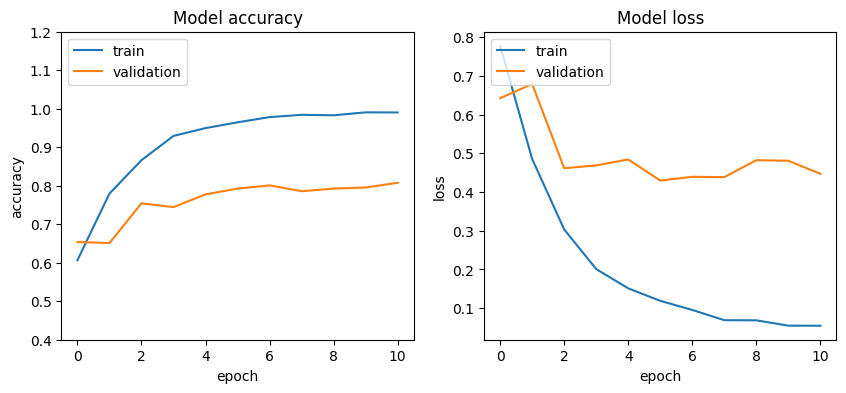

<Figure size 640x480 with 0 Axes>

In [114]:
plot_train_history(model_info_densenet121, report_dir, file_name)

In [118]:
# evaluate model accuracy
score_densenet121=model_densenet121.evaluate(test_ds)
print("Loss:",score_densenet121[0],"Accuracy:",score_densenet121[1])

23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7402 - loss: 0.5465
Loss: 0.4298456311225891 Accuracy: 0.7925823926925659


In [122]:
pred_densenet121= np.round(model_densenet121.predict(test_ds, verbose=0))
test_labels=test_ds.labels
test_pred_labels_densenet121=[]
for i in range(len(pred_densenet121)):
  test_pred_labels_densenet121.append(np.argmax(pred_densenet121[i]))
conf_matrix_densenet121= confusion_matrix(test_pred_labels_densenet121,test_labels)
print (conf_matrix_densenet121)

[[172  66]
 [ 85 405]]


In [123]:
# extract cf matrix entries
TP, FN, FP, TN = conf_matrix_densenet121.ravel()

p = precision(TP, FP)

r = recall(TP, FN)

# Stampa i risultati formattati
print("Precision: ", f"{p:.3f}")
print("Sensitivity: ", f"{r:.3f}")
print("Specificity: ", f"{specificity(TN, FP):.3f}")
print("f1-score: ", f"{f1(p, r):.3f}")
print("f2-score: ", f"{f2(p, r):.3f}")

Precision:  0.669
Sensitivity:  0.723
Specificity:  0.827
f1-score:  0.695
f2-score:  0.711


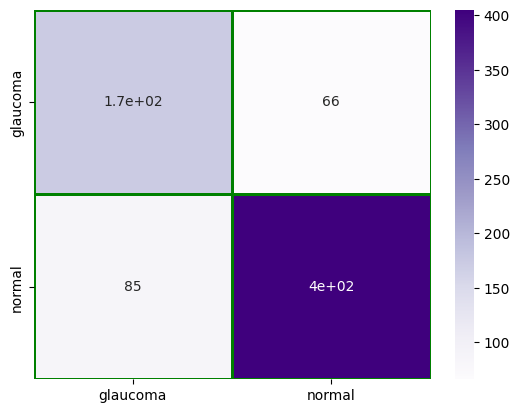

In [124]:
sb.heatmap(conf_matrix_densenet121,cmap='Purples', annot=True,xticklabels=['glaucoma','normal'],yticklabels=['glaucoma','normal'],linewidths=1,
                linecolor='green').plot()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


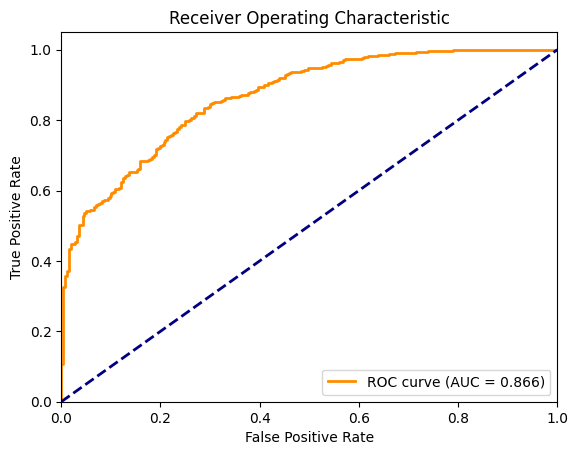

AUC = 0.866


In [125]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Ottieni le etichette reali e le predizioni del modello
test_labels = []
pred_densenet121 = []

# Itera su tutti i batch del generatore di test
for i in range(len(test_ds)):
    images, labels = test_ds[i]
    test_labels.extend(labels)
    pred_batch_densenet121 = model_densenet121.predict(images)
    pred_densenet121.extend(pred_batch_densenet121)

# Converti in numpy array
test_labels = np.array(test_labels)
pred_densenet121 = np.array(pred_densenet121)

# Se le etichette sono one-hot, convertili a 1D
if test_labels.ndim > 1:
    test_labels = np.argmax(test_labels, axis=1)

# Se pred è 2D (con probabilità per ogni classe), prendi solo la probabilità della classe positiva
if pred_densenet121.ndim > 1:
    pred_densenet121 = pred_densenet121[:, 1]

# Step 2: Calcola la curva ROC e l'AUC
fpr_densenet121, tpr_densenet121, _ = roc_curve(test_labels, pred_densenet121)
roc_auc_densenet121 = auc(fpr_densenet121, tpr_densenet121)

# Step 3: Traccia la curva ROC
plt.figure()
plt.plot(fpr_densenet121, tpr_densenet121, color='darkorange', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc_densenet121)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Stampa l'AUC
print('AUC = %0.3f' % roc_auc_densenet121)


In [158]:
### model 5 : InceptionV3 needs different data preprocessing

import os
import shutil
from sklearn.model_selection import train_test_split
from shutil import rmtree

data_dir = current_dir + "//model//InceptionV3//LAG"
train_dir = data_dir + "//train"
test_dir = data_dir + "//test" 
val_dir = data_dir + "//val"

if os.path.exists(data_dir):
	rmtree(data_dir)

# Definisci la proporzione di suddivisione (es: 0.7 per il 70% nel train e il 30% nel test + val)
train_ratio = 0.7
# Definisci la proporzione di suddivisione del set di test (50% in test e 50% in val)
test_val_ratio = 0.5

# Crea le cartelle train, test e val se non esistono
os.makedirs(data_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Per ogni classe nella cartella dataset
for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if os.path.isdir(class_path):
        # Crea le sottocartelle per ogni classe nelle cartelle train, test e val
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        # Ottieni la lista delle immagini
        images = os.listdir(class_path)

        # Dividi in train e test+val
        train_images, test_val_images = train_test_split(images, train_size=train_ratio, random_state=42)

        # Dividi ulteriormente test+val in test e val
        test_images, val_images = train_test_split(test_val_images, train_size=test_val_ratio, random_state=42)

        # Sposta le immagini nella rispettiva cartella
        for image in train_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))

        for image in test_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))

        for image in val_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(val_dir, class_name, image))

print("Divisione train, test e val completata!")

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
datagen_train_inception = ImageDataGenerator(preprocessing_function=preprocess_input,
shear_range = 0.1,
zoom_range = 0.1,
rotation_range = 20,
width_shift_range = 0.1,
height_shift_range = 0.1,
horizontal_flip = False,
vertical_flip = False,
fill_mode='nearest')

datagen_inception = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = datagen_train_inception.flow_from_directory(
    'model//InceptionV3//LAG//train',
    class_mode='categorical',
    shuffle=False)

val_ds = datagen_inception.flow_from_directory(
    'model//InceptionV3//LAG//val',
    class_mode='categorical',
    shuffle=False)

test_ds = datagen_inception.flow_from_directory(
    'model//InceptionV3//LAG//test',
    class_mode='categorical',
    shuffle=False)

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import silu

# Carica il modello VGG16 pre-addestrato senza i livelli fully connected alla fine
base_model_inceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model_inceptionV3.trainable = False

model_inceptionV3 = Sequential()

# Congela i pesi del modello base
for layer in base_model_inceptionV3.layers[-5:]:
    layer.trainable = True

model_inceptionV3.add(base_model_inceptionV3)

# Full connection
model_inceptionV3.add(Flatten())
model_inceptionV3.add(Dense(units = 1028, activation = 'relu'))
model_inceptionV3.add(BatchNormalization()),
model_inceptionV3.add(Dense(512,activation='relu')),
model_inceptionV3.add(Dropout(0.25)),
model_inceptionV3.add(Dense(units = 2, activation = 'softmax'))

# Compila il modello
learning_rate = 0.000005
model_inceptionV3.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Definizione della callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',  # Monitora la loss sul set di validazione
                               patience=5,          # Numero di epoche senza miglioramenti prima di fermarsi
                               restore_best_weights=True)  # Ripristina i pesi del miglior modello

# Definizione della callback ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # Monitora la loss sul set di validazione
                              factor=0.2,          # Fattore di riduzione del tasso di apprendimento
                              patience=3,          # Numero di epoche senza miglioramenti prima di ridurre il tasso
                              min_lr=1e-7)         # Limite inferiore per il tasso di apprendimento


Divisione train, test e val completata!
Found 3397 images belonging to 2 classes.
Found 729 images belonging to 2 classes.
Found 728 images belonging to 2 classes.


In [159]:

initial_epochs = 50

# Train the model
model_info_inceptionV3 = model_inceptionV3.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=test_ds,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.5071 - loss: 0.8898 - val_accuracy: 0.6236 - val_loss: 0.6663 - learning_rate: 5.0000e-06
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.7368 - loss: 0.5452 - val_accuracy: 0.7198 - val_loss: 0.5344 - learning_rate: 5.0000e-06
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.8072 - loss: 0.4226 - val_accuracy: 0.5591 - val_loss: 0.8060 - learning_rate: 5.0000e-06
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.8852 - loss: 0.2951 - val_accuracy: 0.7596 - val_loss: 0.4773 - learning_rate: 5.0000e-06
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9150 - loss: 0.2367 - val_accuracy: 0.7500 - val_loss: 0.4841 - learning_rate: 5.0000e-06
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9353 - loss: 0.2026 - val_accuracy: 0.7253 - val_loss: 0.5552 - learning_rate: 5.0000e-06
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - acc

In [160]:
model_inceptionV3.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 6, 6, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1028)           │    75,793,412 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_294         │ (None, 1028)           │         4,112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 512)            │       526,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,774,868 (956.63 MB)

 Trainable params: 76,323,342 (291.15 MB)

 Non-trainable params: 21,804,840 (83.18 MB)

 Optimizer params: 152,646,686 (582.30 MB)

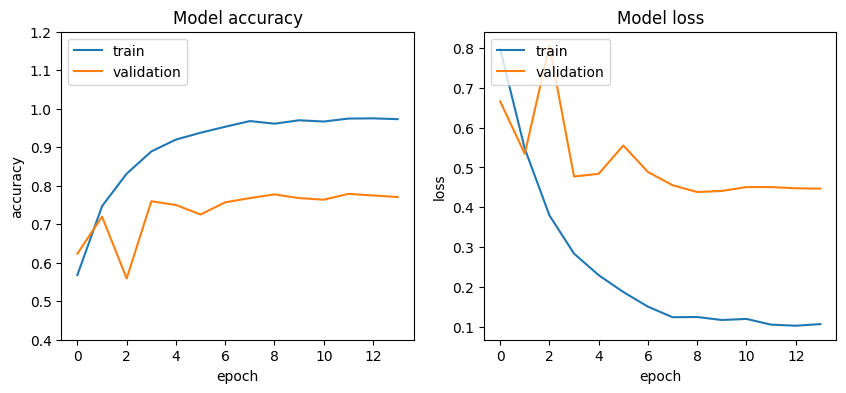

23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 639ms/step - accuracy: 0.6670 - loss: 0.5879
Loss: 0.4383602440357208 Accuracy: 0.7774725556373596
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 699ms/step
[[149  54]
 [108 417]]
Precision:  0.580
Sensitivity:  0.734
Specificity:  0.794
f1-score:  0.648
f2-score:  0.697


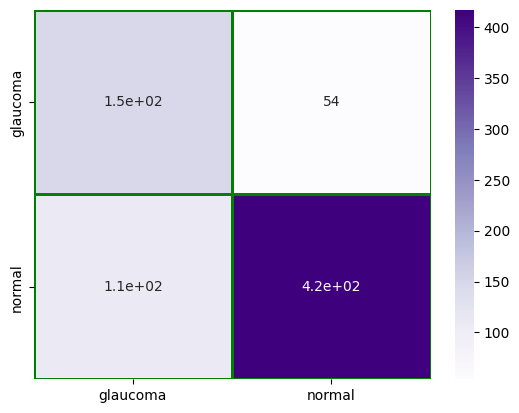

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


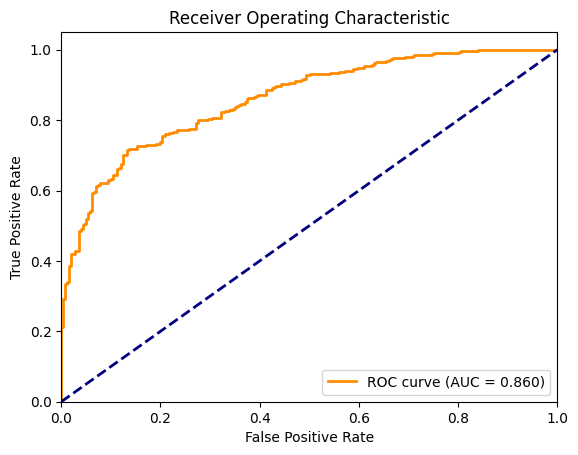

AUC = 0.860


In [161]:
plot_train_history(model_info_inceptionV3, report_dir, file_name)
# evaluate model accuracy
score_inceptionV3=model_inceptionV3.evaluate(test_ds)
print("Loss:",score_inceptionV3[0],"Accuracy:",score_inceptionV3[1])
pred_inceptionV3= np.round(model_inceptionV3.predict(test_ds, verbose=1))
test_pred_labels_inceptionV3=[]
for i in range(len(pred_inceptionV3)):
  test_pred_labels_inceptionV3.append(np.argmax(pred_inceptionV3[i]))
conf_matrix_inceptionV3= confusion_matrix(test_pred_labels_inceptionV3,test_labels)
print (conf_matrix_inceptionV3)
# extract cf matrix entries
TP_inceptionV3, FN_inceptionV3, FP_inceptionV3, TN_inceptionV3 = conf_matrix_inceptionV3.ravel()

precision_inceptionV3 = precision(TP_inceptionV3, FP_inceptionV3)

recall_inceptionV3 = recall(TP_inceptionV3, FN_inceptionV3)

# Stampa i risultati formattati
print("Precision: ", f"{precision_inceptionV3:.3f}")
print("Sensitivity: ", f"{recall_inceptionV3:.3f}")
print("Specificity: ", f"{specificity(TN_inceptionV3, FP_inceptionV3):.3f}")
print("f1-score: ", f"{f1(precision_inceptionV3, recall_inceptionV3):.3f}")
print("f2-score: ", f"{f2(precision_inceptionV3, recall_inceptionV3):.3f}")
sb.heatmap(conf_matrix_inceptionV3,cmap='Purples', annot=True,xticklabels=['glaucoma','normal'],yticklabels=['glaucoma','normal'],linewidths=1,
                linecolor='green').plot()
plt.show()

from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Ottieni le etichette reali e le predizioni del modello
test_labels = []
pred_inceptionV3 = []

# Itera su tutti i batch del generatore di test
for i in range(len(test_ds)):
    images, labels = test_ds[i]
    test_labels.extend(labels)
    pred_batch_inceptionV3 = model_inceptionV3.predict(images)
    pred_inceptionV3.extend(pred_batch_inceptionV3)

# Converti in numpy array
test_labels = np.array(test_labels)
pred_inceptionV3 = np.array(pred_inceptionV3)

# Se le etichette sono one-hot, convertili a 1D
if test_labels.ndim > 1:
    test_labels = np.argmax(test_labels, axis=1)

# Se pred è 2D (con probabilità per ogni classe), prendi solo la probabilità della classe positiva
if pred_inceptionV3.ndim > 1:
    pred_inceptionV3 = pred_inceptionV3[:, 1]

# Step 2: Calcola la curva ROC e l'AUC
fpr_inceptionV3, tpr_inceptionV3, _ = roc_curve(test_labels, pred_inceptionV3)
roc_auc_inceptionV3 = auc(fpr_inceptionV3, tpr_inceptionV3)

# Step 3: Traccia la curva ROC
plt.figure()
plt.plot(fpr_inceptionV3, tpr_inceptionV3, color='darkorange', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc_inceptionV3)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Stampa l'AUC
print('AUC = %0.3f' % roc_auc_inceptionV3)
